## Imports

In [1]:
import tensorflow as tf
import numpy as np
import keras.backend as K
from tqdm import tqdm
from keras.optimizers import Adam
from keras.models import Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import keras

from keras.datasets import mnist
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tqdm
import os.path
import pickle
import math
import random

Using TensorFlow backend.


In [2]:
# Setting seeds for reproducibility 
np.random.seed(0)
tf.set_random_seed(0)

## Parameters

In [3]:
# model params
batch_size = 64               # the number of samples each client trains with per timestep
                              # smaller --> more variety between classes --> better training
num_classes = 10
epochs = 12
train_from_scratch = False    # if True, will train a model from scratch if no weights are found

# client params
clients_per_class = 10        # number of clients per label. Each client only has access to one label
batches_per_train_step = 20   # after averaging the gradients from X clients, we will apply them to the model
shuffle_clients = True

# checkpoint params
checkpoint_folder = "./checkpoints/blackbox"
os.makedirs(checkpoint_folder, exist_ok=True)
blackbox_weights_path = os.path.join(checkpoint_folder, 'blackbox_checkpoint.ckpt')

# dataset params
separated_train_path = "./train_separated.pkl"
separated_test_path = "./test_separated.pkl"

# input image dimensions
img_rows, img_cols = 28, 28
target_rows, target_cols = 28, 28    # governed by the chosen model

## Load Data

In [4]:
# The data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if target_rows != img_rows or target_cols != img_cols:
    # resize x_train
    x_train_resized = []
    for x_ in x_train:
        # scale image to be the same WxH as we need:
        x_ = cv2.resize(x_, dsize=(target_rows, target_cols), interpolation=cv2.INTER_CUBIC)
        x_train_resized.append(x_)
    x_train = np.asarray(x_train_resized)

    # resize x_test
    x_test_resized = []
    for x_ in x_test:
        # scale image to be the same WxH as we need:
        x_ = cv2.resize(x_, dsize=(target_rows, target_cols), interpolation=cv2.INTER_CUBIC)
        x_test_resized.append(x_)
    x_test = np.asarray(x_test_resized)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [5]:
# summary of data shapes:
print('X:', x_train.shape, x_test.shape)
print('y:', y_train.shape, y_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

X: (60000, 28, 28, 1) (10000, 28, 28, 1)
y: (60000, 10) (10000, 10)
60000 train samples
10000 test samples


#### Separate the data by class

In [6]:
# Separating the data by class
if os.path.isfile(separated_train_path):
    with open(separated_train_path, 'rb') as f:
        x_train_dict, y_train_dict = pickle.load(f)
        print('loaded training seperation')
else:
    x_train_dict = {}
    y_train_dict = {}
    for target_label in tqdm_notebook(range(10)):
        x_train_dict[target_label] = []
        y_train_dict[target_label] = []
        for i, label in enumerate(y_train):
            if list(label).index(1) == target_label:
                x_train_dict[target_label].append(x_train[i])
                y_train_dict[target_label].append(y_train[i])
    
    with open(separated_train_path, 'wb') as f:
        pickle.dump([x_train_dict, y_train_dict], f)
        print('saved training seperation')

if os.path.isfile(separated_test_path):
    with open(separated_test_path, 'rb') as f:
        x_test_dict, y_test_dict = pickle.load(f)
        print('loaded testing seperation')
else:
    x_test_dict = {}
    y_test_dict = {}
    for target_label in tqdm_notebook(range(10)):
        x_test_dict[target_label] = []
        y_test_dict[target_label] = []
        for i, label in enumerate(y_test):
            if list(label).index(1) == target_label:
                x_test_dict[target_label].append(x_test[i])
                y_test_dict[target_label].append(y_test[i])

    with open(separated_test_path, 'wb') as f:
        pickle.dump([x_test_dict, y_test_dict], f)
        print('saved testing seperation')
    
# convert dicts to lists
x_train_seperated = [np.array(x_train_dict[i]) for i in range(10)]
y_train_seperated = [np.array(y_train_dict[i]) for i in range(10)]

x_test_seperated = [np.array(x_test_dict[i]) for i in range(10)]
y_test_seperated = [np.array(y_test_dict[i]) for i in range(10)]

loaded training seperation
loaded testing seperation


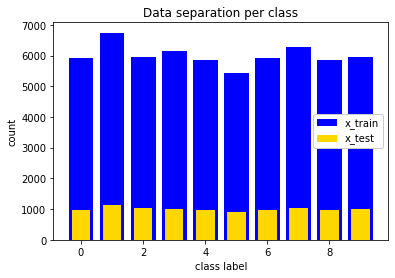

In [7]:
# summary of data shapes:
plt.figure()
plt.title('Data separation per class')
plt.bar(x_train_dict.keys(), [len(v) for v in x_train_dict.values()], color='b')
plt.bar(x_test_dict.keys(), [len(v) for v in x_test_dict.values()], color='gold', width=0.6)
plt.legend(['x_train', 'x_test'], loc='center right', framealpha=1.0)
plt.xlabel('class label')
plt.ylabel('count')
plt.show()

#### Separate the data into batches for clients to use

In [8]:
# Separate the data into a long list of batches, each batch representing a client training with that batch of images.
# After each batch, a new client will have the opportunity to train their batch of images.
# Batches are shuffled to simulate many clients training the model at once.

x_batches = []
y_batches = []

def ceil(a,b):
    return -(-a//b)

for class_idx in range(len(x_train_seperated)):
    # Get batches from class data:
    n_samples = len(x_train_seperated[class_idx])
    better_batch_size = ceil(n_samples, ceil(n_samples, batch_size))

    for i in range(ceil(n_samples, better_batch_size)):
        x_batches.append((class_idx, x_train_seperated[class_idx][i * better_batch_size: (i+1) * better_batch_size]))
        y_batches.append((class_idx, y_train_seperated[class_idx][i * better_batch_size: (i+1) * better_batch_size]))
        
# checks
assert len(x_batches) == len(y_batches)
print(len(x_batches) * batch_size, '~=', x_train.shape[0])
print('batch shape:', x_batches[0][1].shape)

60288 ~= 60000
batch shape: (64, 28, 28, 1)


## Build Model

In [9]:
def create_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

In [10]:
input_shape = (target_rows, target_cols, 1)

model = create_model(input_shape)
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
______________________________________

## Graph Creation

In [11]:
# add place for input and pred label
x = Input(shape=input_shape)
y_pred = model(x)

# add place for truth label
y_true = Input(shape=(num_classes, ))

In [12]:
# define loss function in terms of y_pred and y_true
loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)

# Setup metrics to look at during training:
_, acc_op = tf.metrics.accuracy(labels=tf.argmax(y_true, 1),
                                predictions=tf.argmax(y_pred,1))

## Optimizer definition - nothing different from any classical example
optimizer = tf.train.AdamOptimizer()

In [13]:
# INSPIRED by https://stackoverflow.com/questions/42156957/how-to-update-model-parameters-with-accumulated-gradients

# Fetch a list of our network's trainable parameters.
trainable_vars = tf.trainable_variables()

# Create variables to store accumulated gradients
accumulators = [
    tf.Variable(
        tf.zeros_like(tv.initialized_value()),
        trainable=False
    ) for tv in trainable_vars
]

# Create a variable for counting the number of accumulations
accumulation_counter = tf.Variable(0.0, trainable=False)

# Compute gradients; grad_pairs contains (gradient, variable) pairs
grad_pairs = optimizer.compute_gradients(loss, trainable_vars)

# Create operations which add a variable's gradient to its accumulator.
accumulate_ops = [
    accumulator.assign_add(
        grad
    ) for (accumulator, (grad, var)) in zip(accumulators, grad_pairs)
]

# The final accumulation operation is to increment the counter
accumulate_ops.append(accumulation_counter.assign_add(1.0))

# Update trainable variables by applying the accumulated gradients
# divided by the counter. Note: apply_gradients takes in a list of 
# (grad, var) pairs
train_step = optimizer.apply_gradients(
    [(accumulator / accumulation_counter, var) \
        for (accumulator, (grad, var)) in zip(accumulators, grad_pairs)]
)

# Accumulators must be zeroed once the accumulated gradient is applied.
zero_ops = [
    accumulator.assign(
        tf.zeros_like(tv)
    ) for (accumulator, tv) in zip(accumulators, trainable_vars)
]

# Add one last op for zeroing the counter
zero_ops.append(accumulation_counter.assign(0.0))

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


## Split Training

In [14]:
# Initialize the session
sess = tf.Session()

sess.run(tf.local_variables_initializer())
sess.run(tf.global_variables_initializer())

In [16]:
# Train the model IF we want to, otherwise just use previous
if train_from_scratch and not os.path.isfile(blackbox_weights_path):
    print('Training from scratch...')
    
    # Loop through every class, and apply gradients after that:
    for epoch in range(epochs):
        print('.'*10)
        print('Epoch %s:' % epoch+1)

        batch_idxs = list(range(len(x_batches)))
        if shuffle_clients:
            # shuffle the batches each time
            random.shuffle(batch_idxs)

        # Run the zero_ops to initialize the accumulators
        sess.run(zero_ops)

        # Fancy progress bar
        samples = x_train.shape[0]
        pbar = tqdm_notebook(total=samples)

        # Keep track of average loss/acc per class:
        accs_train = []
        losses_train = []

        # Iterate over every minibatch (client batch):
        grad_feed_dict = dict()
        for i, batch_idx in enumerate(batch_idxs):
            class_idx, x_batch = x_batches[batch_idx]
            _, y_batch = y_batches[batch_idx]

            # get the gradients and determine accuracy/loss of model on training dataset
            _, acc_train, loss_train = sess.run([accumulate_ops, acc_op, loss], feed_dict={x: x_batch, y_true: y_batch})

            # increment pbar
            pbar.update(len(x_batch))

            # add acc and loss metrics for batch:
            accs_train.append(acc_train)
            losses_train.append(np.mean(loss_train))
            pbar.set_description('train_acc={:.3f} | train_loss={:.3f}'.format(np.mean(accs_train), np.mean(losses_train)))

            # perform a train step every batches_per_train_step number of batches:
            if (i > 0 and i % batches_per_train_step == 0) or i == len(batch_idxs) - 1:
                # Run the train_step ops to update the weights based on our accumulated gradients
                sess.run(train_step)

                # zero out the accumulators
                sess.run(zero_ops)

        pbar.update(x_train.shape[0] - pbar.n)
        pbar.close()

        # Calculate test acc and loss
        acc_test, loss_test = sess.run([acc_op, loss], feed_dict={x: x_test, y_true: y_test})

        # Update progress bar
        print('Train Accuracy: {:.3f} | Loss: {:.3f}'.format(np.mean(accs_train), np.mean(losses_train)))
        print('Test Accuracy: {:.3f} | Loss: {:.3f}'.format(acc_test, np.mean(loss_test)))
        print()
        
    # Save the weights
    model.save_weights(blackbox_weights_path)
    print('Saved the updated weights')
        
elif os.path.isfile(blackbox_weights_path):
    model.load_weights(blackbox_weights_path)
    print('Weights found! Loaded previous weights')
    print()
    
    # Calculate test acc and loss
    acc_test, loss_test = sess.run([acc_op, loss], feed_dict={x: x_test, y_true: y_test})

    # Update progress bar
    print('Test Accuracy: {:.3f} | Loss: {:.3f}'.format(acc_test, np.mean(loss_test)))
    
else:
    print('ERROR: either train from scratch, or give a valid weights ckpt file to load from.')

Weights found! Loaded previous weights

Test Accuracy: 0.103 | Loss: 2.304
